# Implementing [ViT](https://arxiv.org/abs/2010.11929)


In [1]:
from IPython.display import clear_output
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from pathlib import Path
import matplotlib.pyplot as plt
import os
# from torch.utils.tensorboard import SummaryWriter
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Acquisition

In [3]:
BASE_DIR = Path("./pizza_steak_sushi")
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"

In [4]:
if not BASE_DIR.exists():
    !wget https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip -O {BASE_DIR}.zip
    !unzip pizza_steak_sushi.zip -d {BASE_DIR}
    clear_output()

# Dataset & DataLoader

In [5]:
RESOLUTION = 224

train_transforms = transforms.Compose([
    transforms.Resize((RESOLUTION,RESOLUTION)),
    transforms.ToTensor()
])

test_transforms = train_transforms

In [6]:
train = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_transforms)
test = datasets.ImageFolder(root=str(TEST_DIR), transform=test_transforms)

In [7]:
train.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [8]:
BATCH_SIZE = 32

train_dl = DataLoader(
    dataset=train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count() or 1
)

test_dl = DataLoader(
    dataset=test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count() or 1
)

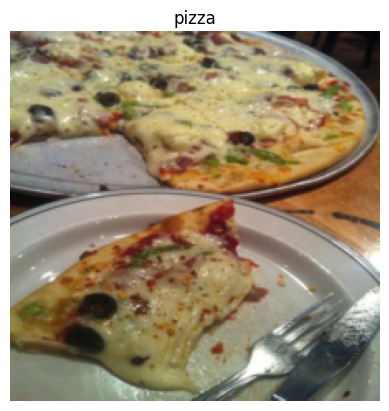

In [9]:
img_batch, label_batch = next(iter(train_dl))
img, label = img_batch[0], label_batch[0]
plt.title(train.classes[label])
plt.axis(False)
plt.imshow(img.permute(1, 2, 0))
plt.show()

# ViT

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)


## Patch Embedding

(Notes for raw image patches)

### Image

An RGB image of size 224x224.

(1, 224, 224, 3)

### Pathes

We are using 16x16 patches so we will get 196 patches.

(196, 16, 16, 3)

### Flattened patches

Sequence of 196 vectors fo size 768.

(196, 768)

[$x_p^1, x_p^2, ..., x_p^{196}$]

### Class Token

The class token is a learnable paramter that is added to prepended to each image. It is of the same dimension as the image embedding.

(197, 768)

[$class\_token,x_p^1, x_p^2, ..., x_p^{196}$]

To keep the sizes consisten the class token will be of shape (1, 768)

### Positional Embedding

According to the paper, the positional embedding is added to the patch embedding so which will retain the shape.

The positions are just real numbers that are learnable.

In [103]:
class PatchEmbedding(nn.Module):
    def __init__(self, patch_size=16, embedding_dim=768, img_size=224):
        super().__init__()

        ## this uses convolutional feature maps to replace raw patches
        ## see "Hybrid Architecture" in ViT section 3.1
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=3,
                out_channels=embedding_dim,
                kernel_size=patch_size,
                stride=patch_size,
                padding=0,
            ),
            nn.Flatten(start_dim=2)
        )

        number_patches = img_size**2//patch_size**2

        self.class_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.positional_embedding = nn.Parameter(torch.randn(number_patches+1, embedding_dim))

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_token.expand(batch_size, -1, -1)
        image_embedding = self.patcher(x).permute(0,2,1)

        return torch.cat((class_token, image_embedding), dim=1) + self.positional_embedding

In [104]:
patch_embedding = PatchEmbedding()
embedding = patch_embedding(img_batch)
# [batch_size, sequence_length, embedding_dim]
embedding.shape

torch.Size([32, 197, 768])

## Transformer Encoder

In [105]:
class MultiHeadSelfAttentionBlock(nn.Module):
    # Multi-Head Attention
    def __init__(self, embedding_dim, num_heads):
        super().__init__()

        self.norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.attn_head = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            batch_first=True
        )


    def forward(self, x):
        x_norm = self.norm(x)
        attn_output, _ = self.attn_head(key=x_norm, query=x_norm, value=x_norm, need_weights=False)
        return attn_output

In [106]:
msa_block = MultiHeadSelfAttentionBlock(embedding_dim=768, num_heads=12)
msa_out = msa_block(embedding)
msa_out.shape

torch.Size([32, 197, 768])

In [107]:
class MultiLayerPreceptronBlock(nn.Module):
    def __init__(self, embedding_dim, mlp_size):
        super().__init__()

        self.norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
        )

    def forward(self, x):
        x_norm = self.norm(x)
        mlp_out = self.mlp(x_norm)
        return mlp_out

In [108]:
mlp_block = MultiLayerPreceptronBlock(embedding_dim=768, mlp_size=3072)
mlp_out = mlp_block(msa_out)
mlp_out.shape

torch.Size([32, 197, 768])

In [109]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, mlp_size=3072):
        super().__init__()

        self.attn_head = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim, num_heads=num_heads)
        self.mlp_head = MultiLayerPreceptronBlock(embedding_dim=embedding_dim, mlp_size=mlp_size)

    def forward(self, x):
        x = self.attn_head(x) + x
        x = self.mlp_head(x) + x
        return x

In [110]:
encoder = TransformerEncoder()
latent = encoder(embedding)
latent.shape

torch.Size([32, 197, 768])

## Classification Head

In [100]:
class ClassificationHead(nn.Module):
    def __init__(self, in_features=768, num_classes=3):
        super().__init__()

        self.model = nn.Sequential(
            nn.LayerNorm(normalized_shape=in_features),
            nn.Linear(in_features=in_features, out_features=num_classes)
        )

    def forward(self, x):
        return self.model(x)

## ViT

In [101]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        embedding_dim=768,
        num_transformer_layers=12,
        mlp_size=3072,
        num_heads=12,
        num_classes=3
    ):
        super().__init__()

        self.patcher = PatchEmbedding(patch_size=patch_size, embedding_dim=embedding_dim, img_size=img_size)

        self.encoder = nn.Sequential(*[TransformerEncoder(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size
            ) for _ in range(num_transformer_layers)])

        self.classifier = ClassificationHead(
            in_features=embedding_dim,
            num_classes=num_classes
        )

    def forward(self, x):
        embedding = self.patcher(x)
        features = self.encoder(embedding)[:, 0]
        return self.classifier(features)

In [111]:
vit = ViT().to(device)
out = vit(img_batch.to(device))
out.shape

torch.Size([32, 3])

## Training

In [119]:
def fit(model: nn.Module, dl: DataLoader, val_dl: DataLoader, optim: torch.optim.Optimizer, criterion: nn.Module, epochs=2):
    train_loss = []
    val_loss = []

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        batch_acc = []

        for i, (x, y) in enumerate(dl):

            x, y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out, y)

            batch_loss.append(loss.item())

            # accuracy calculation
            acc = (torch.softmax(out, dim=1).argmax(dim=1) == y).sum() / len(y)
            batch_acc.append(acc.item())

            optim.zero_grad()
            loss.backward()
            optim.step()

        epoch_train_loss = np.mean(np.array(batch_loss))
        epoch_train_accuracy = np.mean(np.array(batch_acc))

        train_loss.append(epoch_train_loss)

        model.eval()

        with torch.inference_mode():

            batch_loss = []
            batch_acc = []

            for i, (x, y) in enumerate(val_dl):

                x, y = x.to(device), y.to(device)

                out = model(x)
                loss = criterion(out, y)

                batch_loss.append(loss.item())

                # accuracy calculation
                acc = (torch.softmax(out, dim=1).argmax(dim=1) == y).sum() / len(y)
                batch_acc.append(acc.item())

        epoch_val_loss = np.mean(np.array(batch_loss))
        epoch_val_accuracy = np.mean(np.array(batch_acc))

        val_loss.append(epoch_val_loss)

        if 1:
            print(f"Epoch {epoch}/{epochs} | Train Loss: {epoch_train_loss} | Val Accruacy: {epoch_val_accuracy}")

    return train_loss, val_loss

In [120]:
def plot_hist(train_loss, val_loss):
    plt.figure(figsize=(10,5))
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.legend(["Train", "Val"])
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

In [121]:
vit = ViT().to(device)

In [122]:
LR = 1e-3
EPOCHS = 10

optimizer = torch.optim.Adam(lr=LR, params=vit.parameters(), weight_decay=0.1)
criterion = nn.CrossEntropyLoss()

In [123]:
train_loss, val_loss = fit(vit, train_dl, test_dl, optimizer, criterion, epochs=EPOCHS)

Epoch 0/10 | Train Loss: 3.9581921696662903 | Val Accruacy: 0.4223484893639882
Epoch 1/10 | Train Loss: 1.5964531376957893 | Val Accruacy: 0.32007576028505963
Epoch 2/10 | Train Loss: 1.2725391238927841 | Val Accruacy: 0.3399621248245239
Epoch 3/10 | Train Loss: 1.906055897474289 | Val Accruacy: 0.4621212085088094
Epoch 4/10 | Train Loss: 1.4752569943666458 | Val Accruacy: 0.25757576028505963
Epoch 5/10 | Train Loss: 1.2967282831668854 | Val Accruacy: 0.4422348539034526
Epoch 6/10 | Train Loss: 1.1821505650877953 | Val Accruacy: 0.3399621248245239
Epoch 7/10 | Train Loss: 1.2218293249607086 | Val Accruacy: 0.32007576028505963
Epoch 8/10 | Train Loss: 1.2162982672452927 | Val Accruacy: 0.32007576028505963
Epoch 9/10 | Train Loss: 1.1768995821475983 | Val Accruacy: 0.2973484893639882


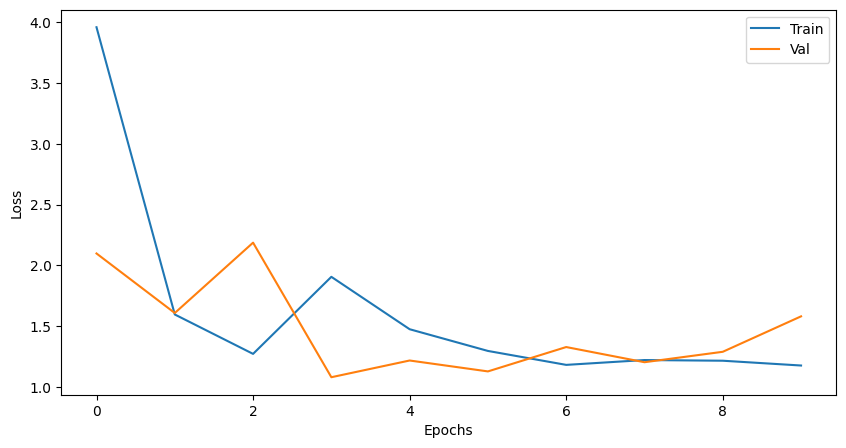

In [124]:
plot_hist(train_loss, val_loss)

# Pretrained ViT

In [125]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

In [126]:
weights = ViT_B_16_Weights.DEFAULT
weights

ViT_B_16_Weights.IMAGENET1K_V1

In [127]:
weights.transforms()

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [128]:
train_transforms = weights.transforms()
test_transforms = weights.transforms()

In [129]:
train = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_transforms)
test = datasets.ImageFolder(root=str(TEST_DIR), transform=test_transforms)

In [152]:
BATCH_SIZE = 32

train_dl = DataLoader(
    dataset=train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count() or 1
)

test_dl = DataLoader(
    dataset=test,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=os.cpu_count() or 1
)

In [158]:
vit = vit_b_16(weights=ViT_B_16_Weights, progress=False).to(device)

In [159]:
for param in vit.parameters():
    param.requires_grad = False

vit.heads = nn.Sequential(
    nn.Linear(in_features=768, out_features=len(train.classes))
).to(device)

In [160]:
LR = 1e-4
EPOCHS = 20

optimizer = torch.optim.Adam(lr=LR, params=vit.parameters())
criterion = nn.CrossEntropyLoss()

In [161]:
train_loss, val_loss = fit(vit, train_dl, test_dl, optimizer, criterion, epochs=EPOCHS)

Epoch 0/20 | Train Loss: 1.0495846569538116 | Val Accruacy: 0.5662878751754761
Epoch 1/20 | Train Loss: 0.953770823776722 | Val Accruacy: 0.7102272907892863
Epoch 2/20 | Train Loss: 0.8573368042707443 | Val Accruacy: 0.7528409163157145
Epoch 3/20 | Train Loss: 0.8018879219889641 | Val Accruacy: 0.7632575829823812
Epoch 4/20 | Train Loss: 0.719254270195961 | Val Accruacy: 0.7736742496490479
Epoch 5/20 | Train Loss: 0.6546031609177589 | Val Accruacy: 0.8049242496490479
Epoch 6/20 | Train Loss: 0.7067809030413628 | Val Accruacy: 0.8655303120613098
Epoch 7/20 | Train Loss: 0.6421517804265022 | Val Accruacy: 0.8361742496490479
Epoch 8/20 | Train Loss: 0.5468827895820141 | Val Accruacy: 0.8664772907892863
Epoch 9/20 | Train Loss: 0.5917801037430763 | Val Accruacy: 0.8863636453946432
Epoch 10/20 | Train Loss: 0.5242156609892845 | Val Accruacy: 0.8863636453946432
Epoch 11/20 | Train Loss: 0.4515358507633209 | Val Accruacy: 0.8664772907892863
Epoch 12/20 | Train Loss: 0.5129407905042171 | Val A

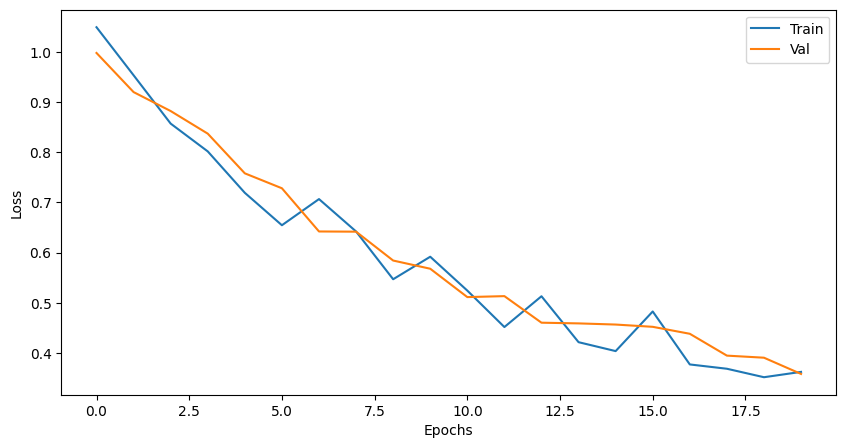

In [162]:
plot_hist(train_loss, val_loss)